In [1]:
import pickle

import json

import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

# sns.set(style="whitegrid")
sns.set_context("talk")

In [34]:
ecc_roi_names = {
    -1: "non_cortical",
    0: "cortical",
    1: "0.5 deg",
    2: "1 deg",
    3: "2 deg",
    4: "4 deg",
    5: ">4 deg",
}

visual_roi_names = {
    -1: "non_cortical",
    0: "cortical",
    1: "V1v",
    2: "V1d",
    3: "V2v",
    4: "V2d",
    5: "V3v",
    6: "v3d",
    7: "h4v"}

place_roi_names = {
    -1: "non_cortical",
    0: "cortical",
    1: "OPA",
    2: "PPA",
    3: "RSC",
}

In [35]:
# roi = ["prf-eccrois", "floc-places", "prf-visualrois"]
roi_dict = {}
roi_dict["prf-eccrois"] = ecc_roi_names
roi_dict["floc-places"] = place_roi_names
roi_dict["prf-visualrois"] = visual_roi_names
# roi_dict["all"] = ecc_roi_names.update(place_roi_names).update(visual_roi_names)

In [5]:
# task_list = ["edge2d", "edge3d", "class_places", "vanishing_point", "inpainting_whole", "room_layout"]

In [46]:
TOI = ["edge2d", \
       "edge3d", \
       "class_places", \
       "class_1000", \
       "vanishing_point", \
       "room_layout", \
       "inpainting_whole", \
       "rgb2sfnorm", \
       "segment2d"]

In [47]:
def load_data(model, task, subj, measure="corr"):
    output = pickle.load(
        open(
            "../output/encoding_results/subj%d/%s_%s_%s_whole_brain.p"
            % (subj, measure, model, task),
            "rb",
        )
    )
    if measure == "corr":
        out = np.array(output)[:, 0]
    else:
        out = np.array(output)
    return out

def get_voxels(model_list, subj):
    datamat = list()
    for l in model_list:
        data = load_data("taskrepr", task=l, subj=subj, measure="corr")
        datamat.append(data)
    datamat = np.array(datamat)
    return datamat

def extract_roi_mapping(roi, cortical_mask, subj):
    "return 3d intersectin of cortical mask and ROI mask"
    roi_3d_mask = nib.load("../output/voxels_masks/subj%d/%s.nii.gz" % (subj, roi)).get_fdata()
#     print(np.sum(roi_3d_mask>-1))
    assert cortical_mask.shape == roi_3d_mask.shape
    roi_mask_map = cortical_mask * (roi_3d_mask>-1)
    return roi_mask_map

def map_from_cortical_to_roi(roi_mapping, cortical_mask, values):
    vol = np.zeros(cortical_mask.shape)
    vol[cortical_mask] = values
    output = vol[roi_mapping] 
    return output


def make_df(roi, subj, task_list):
    try:
        cortical_mask = np.load("../output/voxels_masks/subj%d/cortical_mask_subj%02d.npy" % (subj,subj))
    except FileNotFoundError:
        cortical_mask = np.load("../output/voxels_masks/subj%d/old/cortical_mask_subj%02d.npy" % (subj,subj))
    roi_3d_mask = nib.load("../output/voxels_masks/subj%d/%s.nii.gz" % (subj, roi)).get_fdata()
    voxel_mat = get_voxels(task_list, subj=subj)
    print(voxel_mat.shape)

    with open("../output/encoding_results/subj%s/fdr_threshold.json" % subj) as f:
        thresholds_dict = json.load(f)
        
    # create dataframe
    dfpath = "../output/dataframes/correlations_subj%d_no_sig_mask_%s.csv" % (subj, roi)

    print("Making a new dataframe...")
    task_cols = [task for task in task_list]
    cols = [roi] + task_cols
    df = pd.DataFrame(columns=cols)

    roi_mask_map = extract_roi_mapping(roi, cortical_mask, subj)
    roi_nums = roi_3d_mask[roi_mask_map]
    roi_labels = [roi_dict[roi][int(k)] for k in roi_nums]
    df[roi] = roi_labels
    
    for i, task in enumerate(task_list):
        dat = map_from_cortical_to_roi(roi_mask_map, cortical_mask, voxel_mat[i,:])
        threshold = thresholds_dict[task]
        dat[dat<threshold] = np.nan
        df[task] = dat

    df.to_csv(dfpath)
    return df


def make_full_df(roi_list, subj, task_list):
    try:
        cortical_mask = np.load("../output/voxels_masks/subj%d/cortical_mask_subj%02d.npy" % (subj,subj))
    except FileNotFoundError:
        cortical_mask = np.load("../output/voxels_masks/subj%d/old/cortical_mask_subj%02d.npy" % (subj,subj))
    
    voxel_mat = get_voxels(task_list, subj=subj)
    print(voxel_mat.shape)

    with open("../output/encoding_results/subj%s/fdr_threshold.json" % subj) as f:
        thresholds_dict = json.load(f)
        
    # create dataframe
    dfpath = "../output/dataframes/correlations_subj%d_no_sig_mask_all_roi.csv" % subj

    print("Making a new dataframe...")
    
    
    task_cols = [task for task in task_list]
    superset_mask = None
    
    for roi in roi_list:
        cols = [roi] + task_cols
        
        roi_3d_mask = nib.load("../output/voxels_masks/subj%d/%s.nii.gz" % (subj, roi)).get_fdata()
        
        # get the intersection of cortical mask and roi mask (in 3D)
        roi_mask_map = extract_roi_mapping(roi, cortical_mask, subj)
        if superset_mask is None:
            superset_mask = roi_mask_map
        else:
            superset_mask = (superset_mask + roi_mask_map).astype(bool)
    
    df = pd.DataFrame(columns=cols)
    
    for roi in roi_list:
        roi_3d_mask = nib.load("../output/voxels_masks/subj%d/%s.nii.gz" % (subj, roi)).get_fdata()
        
        # to get the 2d array of ROI values
        roi_nums = roi_3d_mask[superset_mask]
        
        # translate from values to labels
        roi_labels = [roi_dict[roi][int(k)] for k in roi_nums]
        df[roi] = roi_labels
        
    
    
    for i, task in enumerate(TOI):
        dat = map_from_cortical_to_roi(superset_mask, cortical_mask, voxel_mat[i,:])
        threshold = thresholds_dict[task]
        dat[dat<threshold] = np.nan
        df[task] = dat

    df.to_csv(dfpath)
    return df


### Make dataframe

In [48]:
subj = 7
df_dict = {}
for roi in roi_dict.keys():
    d = make_df(roi, subj, TOI)
    df_dict[roi] = d
    print(len(d))

(9, 90184)
Making a new dataframe...
85954
(9, 90184)
Making a new dataframe...
85953
(9, 90184)
Making a new dataframe...
85962


In [76]:
subj = 2
full_df = make_full_df(list(roi_dict.keys()), subj, TOI)
print(len(full_df))

(9, 107785)
Making a new dataframe...
102692


In [77]:
full_df

,prf-visualrois,edge2d,edge3d,class_places,class_1000,vanishing_point,room_layout,inpainting_whole,rgb2sfnorm,segment2d,prf-eccrois,floc-places
0,cortical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cortical,cortical
1,cortical,0.071117,NaN,0.049886,NaN,NaN,NaN,0.072786,NaN,0.057444,cortical,cortical
2,cortical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cortical,cortical
3,cortical,NaN,NaN,NaN,0.047075,NaN,NaN,NaN,NaN,NaN,cortical,cortical
4,cortical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cortical,cortical
...,...,...,...,...,...,...,...,...,...,...,...,...
102687,cortical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cortical,cortical
102688,cortical,NaN,NaN,NaN,0.053978,NaN,NaN,NaN,NaN,NaN,cortical,cortical
102689,cortical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cortical,cortical
102690,cortical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cortical,cortical


## Plot performances according to rois

In [78]:
def violinplot_by_task_across_roi(roi):
    sns.set_style("whitegrid")
    sns.set_context("talk")
#     df = df_dict[roi]
    df = full_df
    plot_n = np.ceil(np.sqrt(len(TOI))).astype(int)
#     roi_n = len(roi_dict[roi].values())
    fig, axes = plt.subplots(ncols=plot_n, nrows=plot_n, figsize=(40,20),sharey=True)
    for i, ax in enumerate(axes.flat):
        try:
            sns.boxplot(x=df[roi], y=TOI[i], data=df, ax=ax, order=list(roi_dict[roi].values()))
        except IndexError:
            continue
        ax.set_title(TOI[i])
    plt.tight_layout()
    plt.savefig("../figures/task_comparison/violinplot_by_task_across_roi_subj%d_%s.png" % (subj,roi))

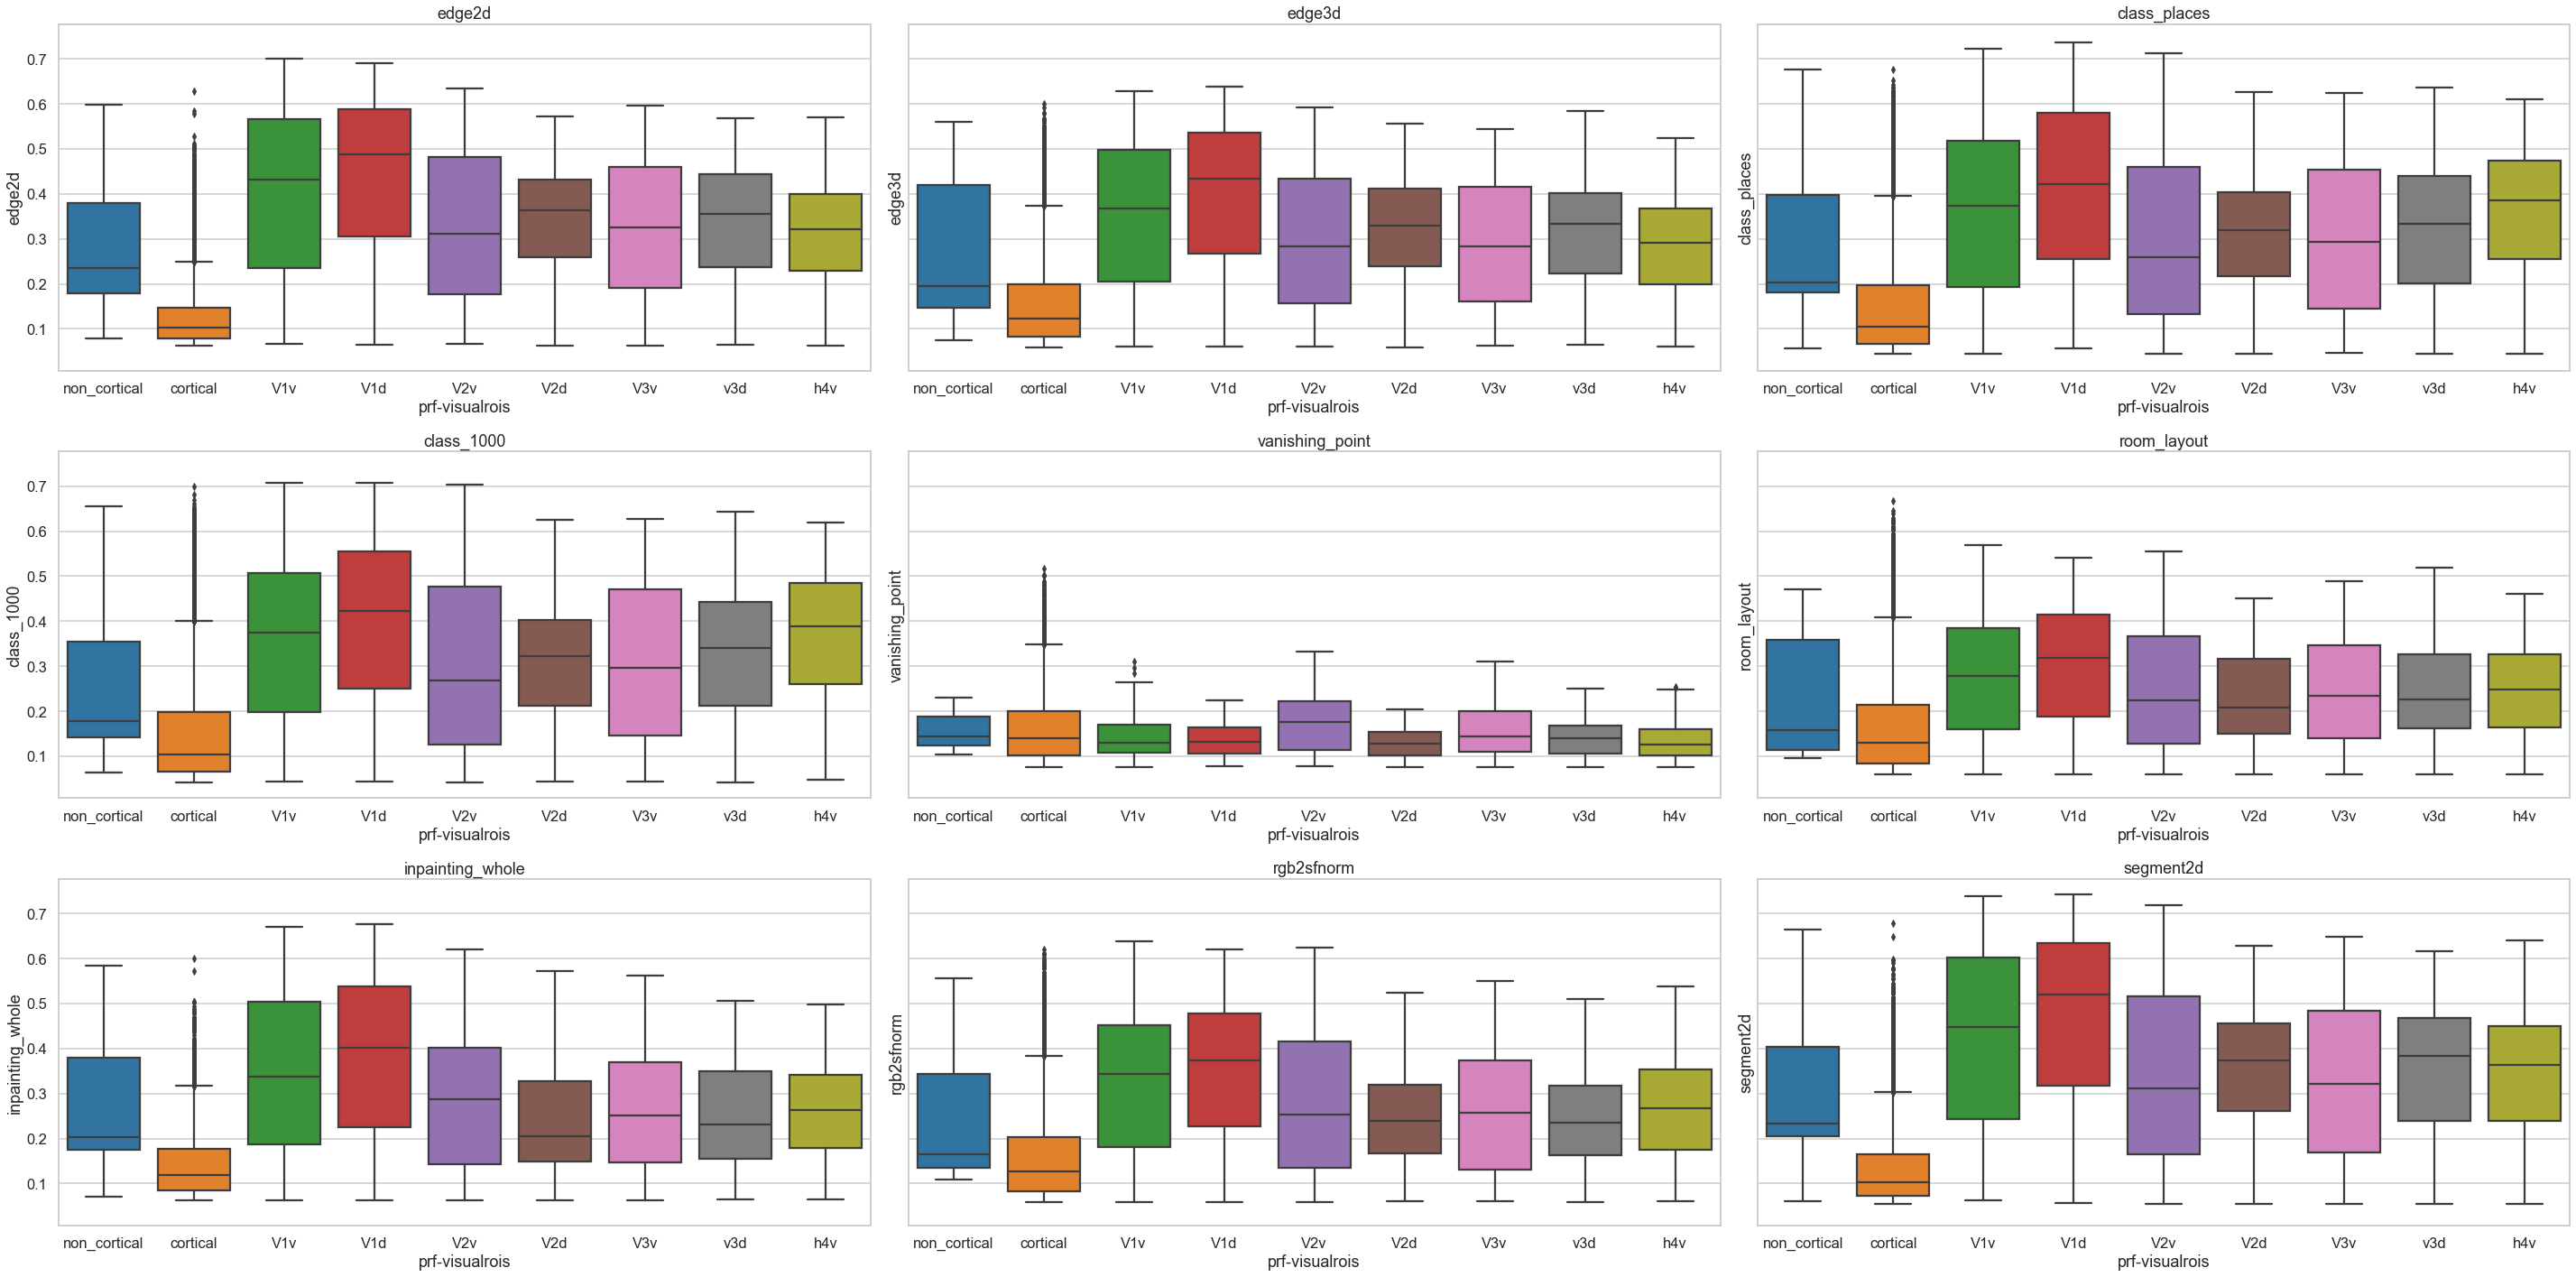

In [79]:
violinplot_by_task_across_roi("prf-visualrois")

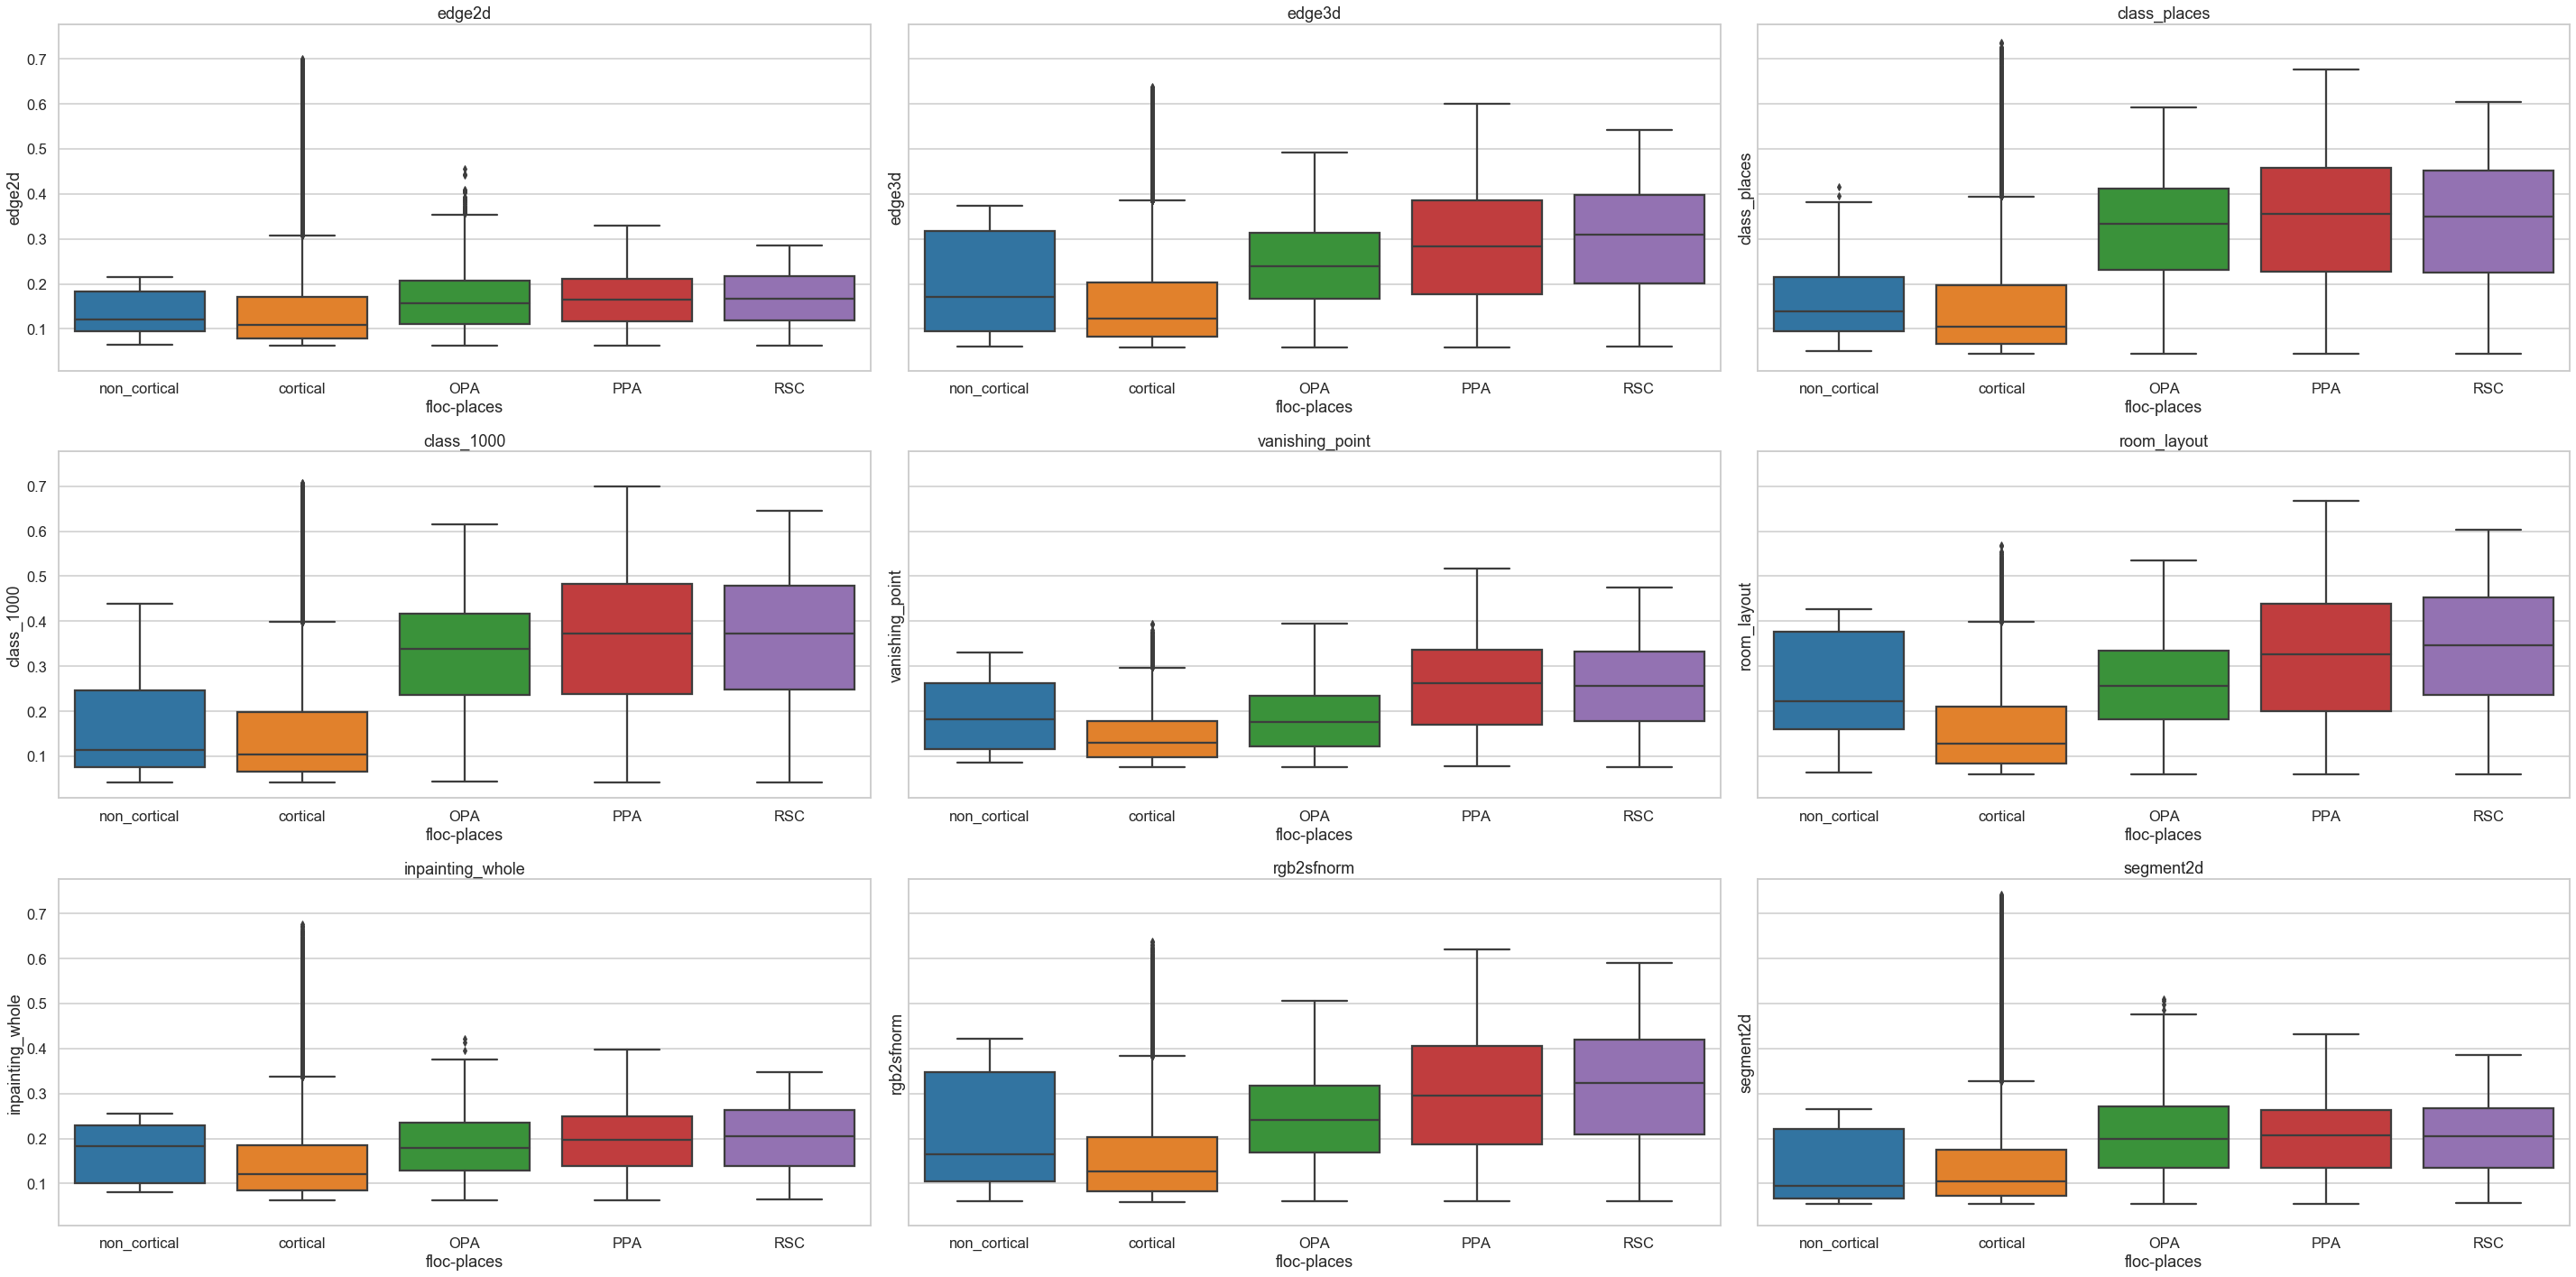

In [80]:
violinplot_by_task_across_roi("floc-places")

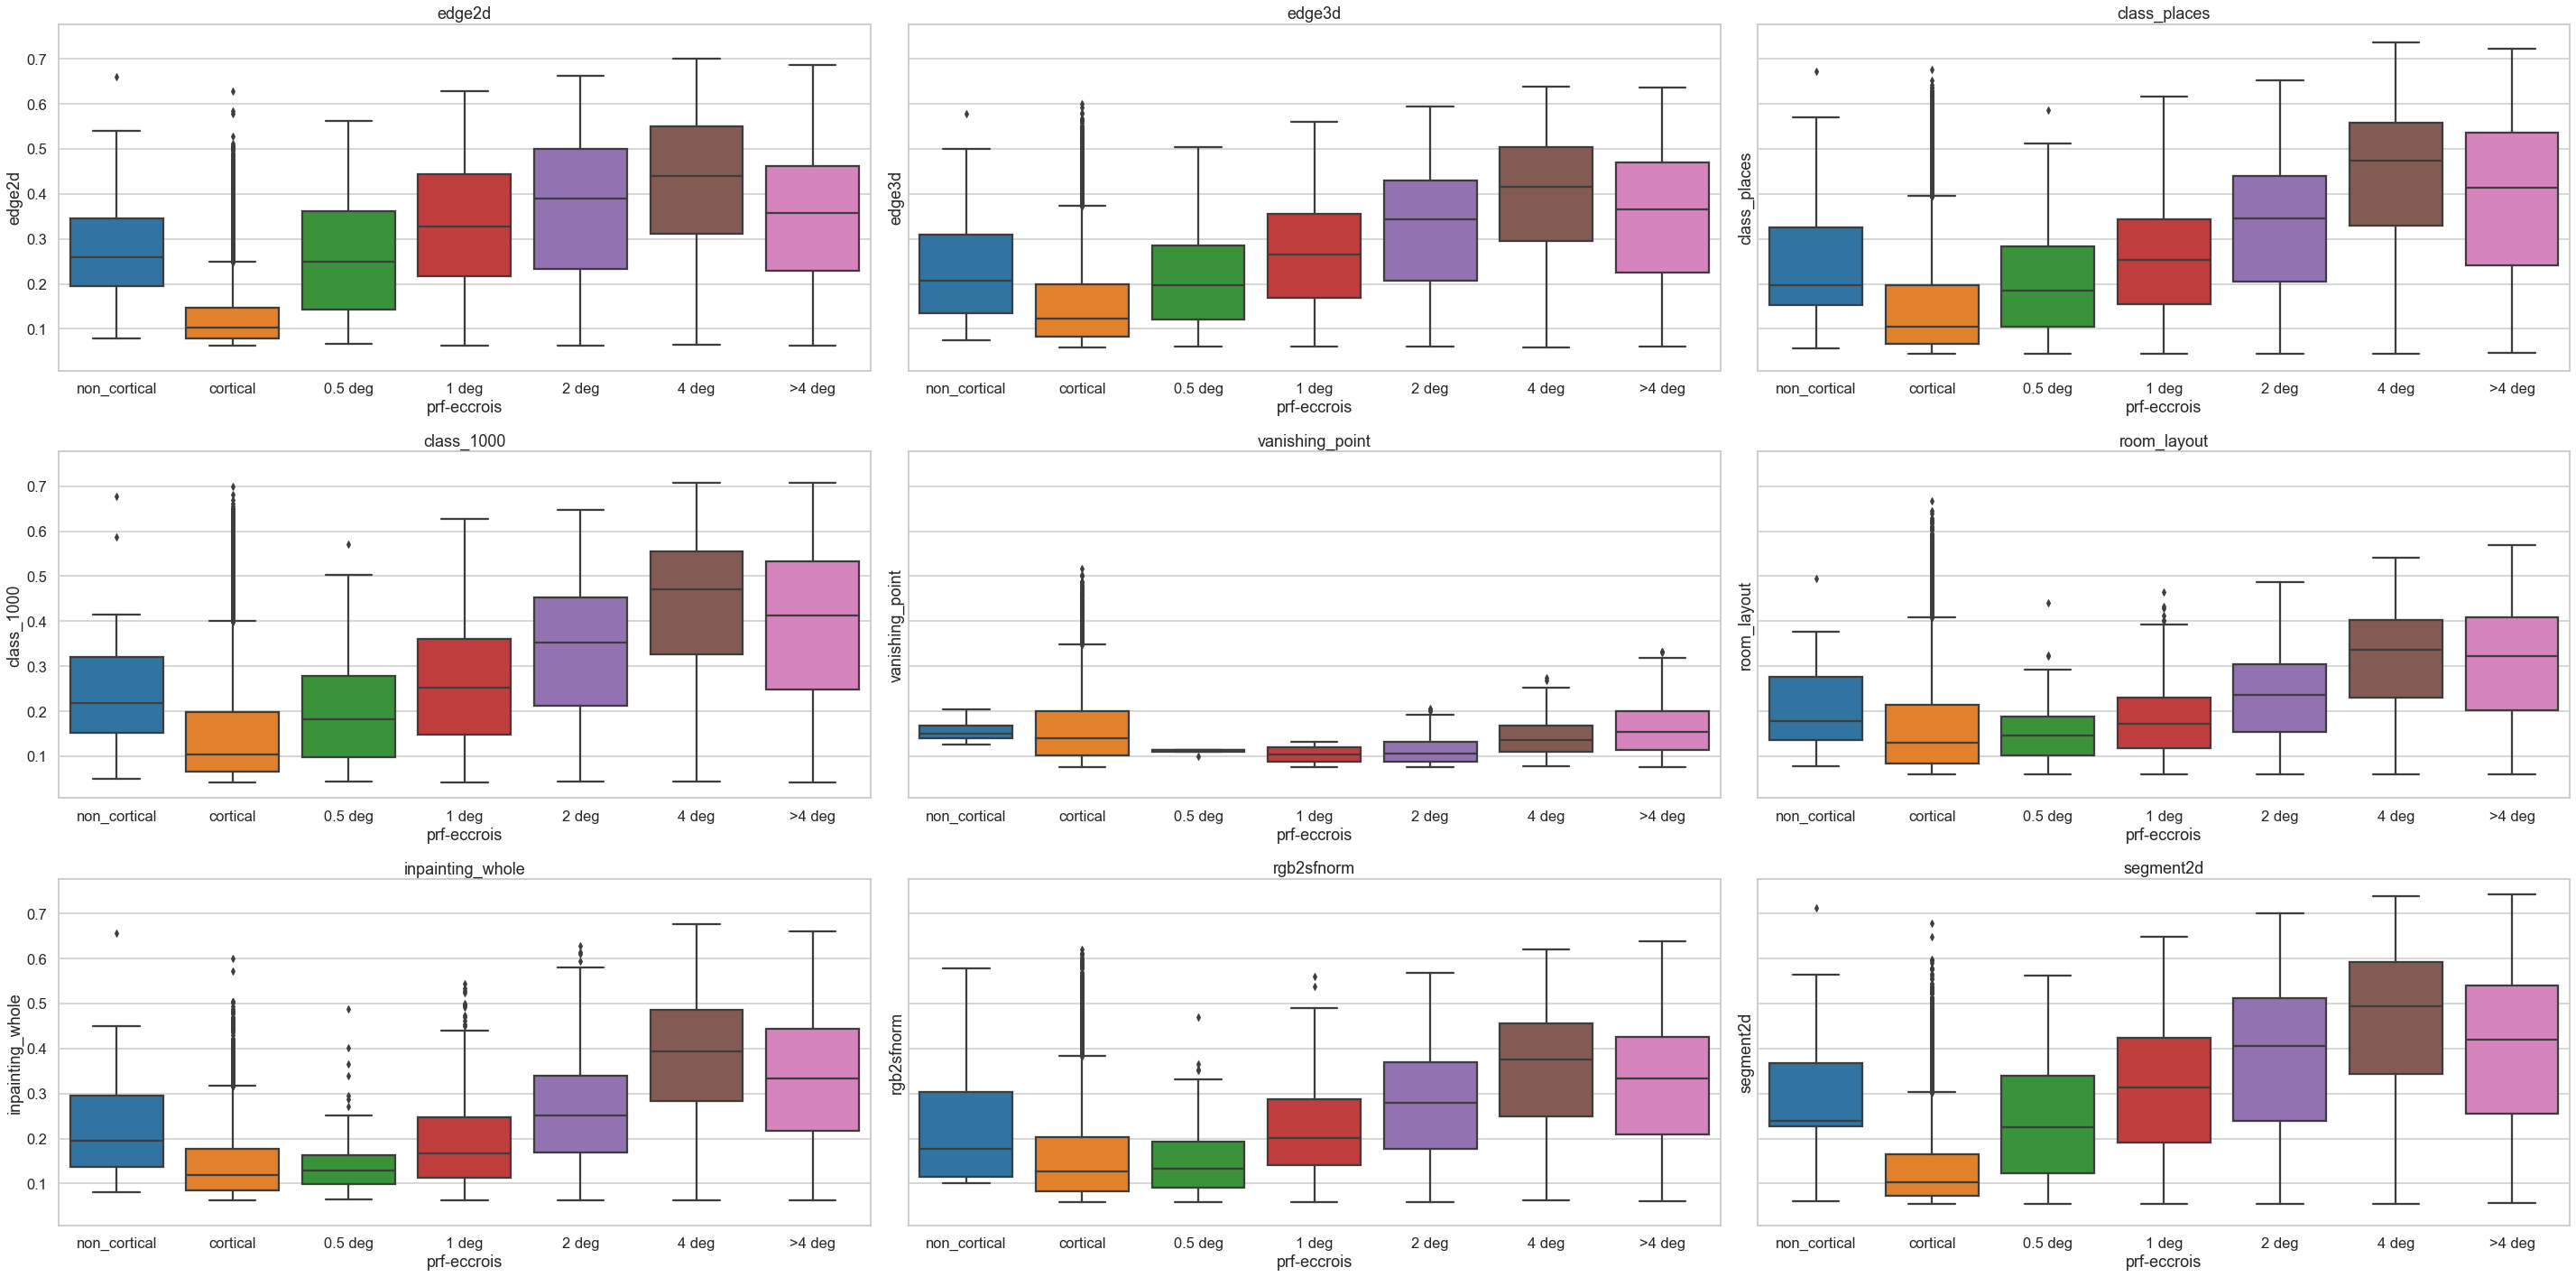

In [81]:
violinplot_by_task_across_roi("prf-eccrois")

In [82]:
def violinplot_by_task_across_roi_ventral_only(roi):
    sns.set_style("whitegrid")
    sns.set_context("talk")
    df = full_df[(full_df["prf-visualrois"] == "V1v") | (full_df["prf-visualrois"] == "V2v") | (full_df["prf-visualrois"] == "V3v")]
    plot_n = np.ceil(np.sqrt(len(TOI))).astype(int)
#     roi_n = len(roi_dict[roi].values())
    fig, axes = plt.subplots(ncols=plot_n, nrows=plot_n, figsize=(40,20),sharey=True)
    for i, ax in enumerate(axes.flat):
        try:
            sns.boxplot(x=df[roi], y=TOI[i], data=df, ax=ax, order=list(roi_dict[roi].values()))
        except IndexError:
            continue
        ax.set_title(TOI[i])
    plt.tight_layout()
    plt.savefig("../figures/task_comparison/violinplot_by_task_across_roi_ventral_only_subj%d_%s.png" % (subj,roi))

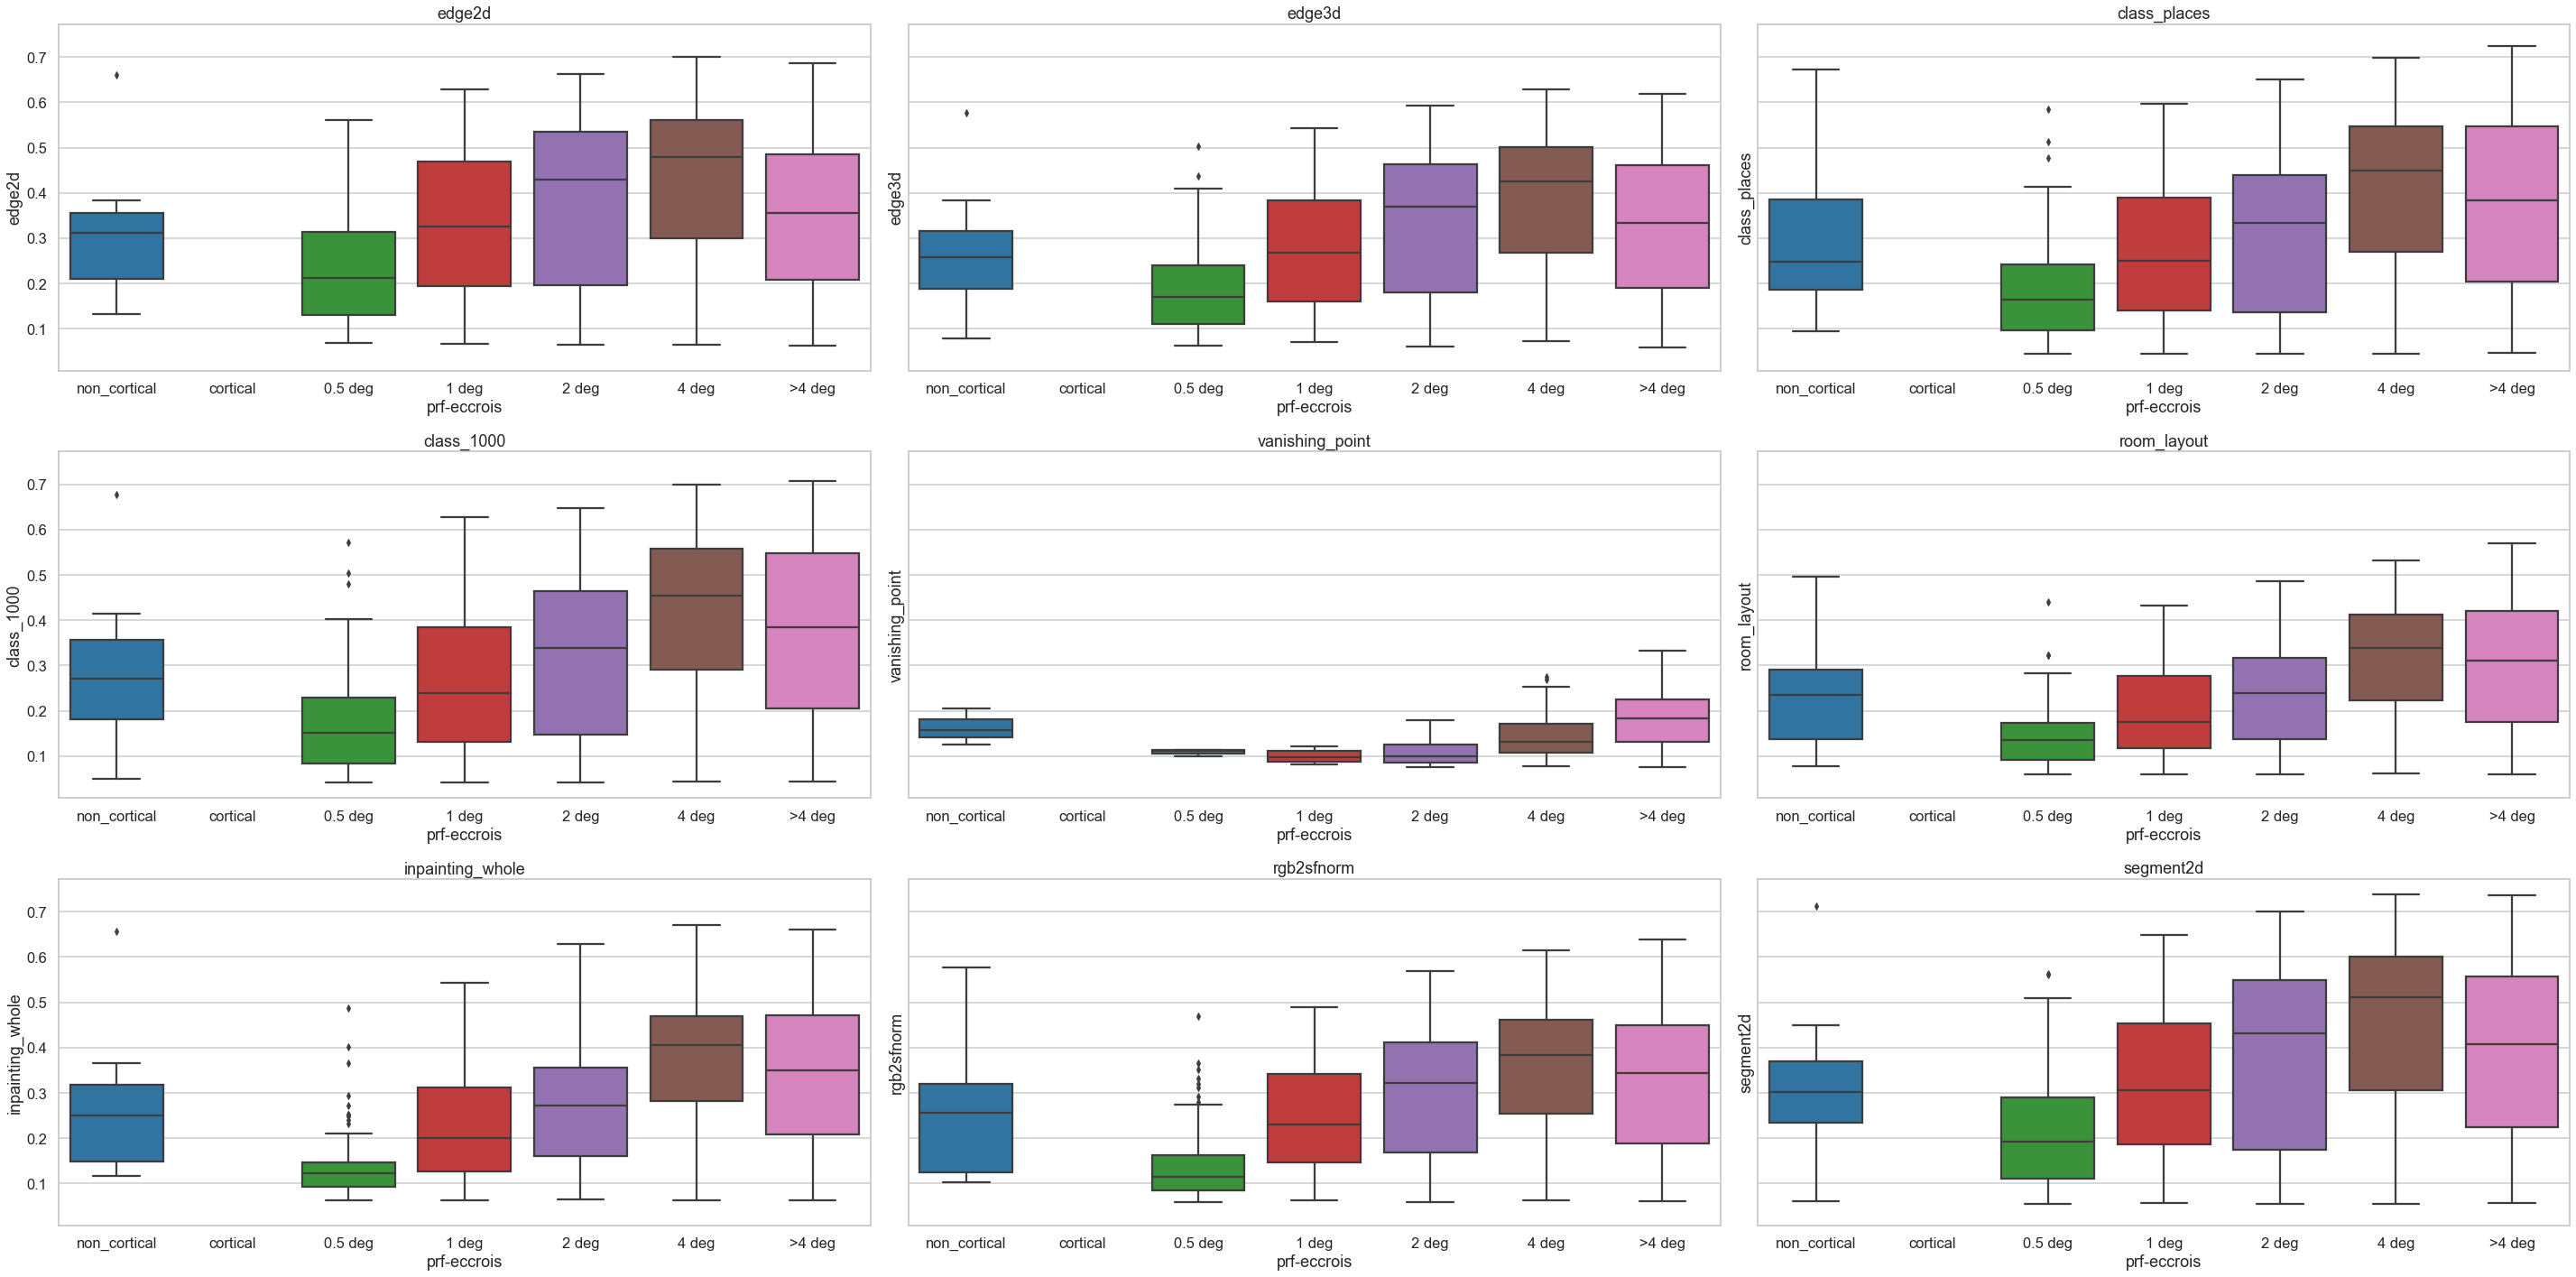

In [83]:
violinplot_by_task_across_roi_ventral_only("prf-eccrois")

In [86]:
def violinplot_by_task_across_roi_dorsal_only(roi):
    sns.set_style("whitegrid")
    sns.set_context("talk")
    df = full_df[(full_df["prf-visualrois"] == "V1d") | (full_df["prf-visualrois"] == "V2d") | (full_df["prf-visualrois"] == "V3d")]
    plot_n = np.ceil(np.sqrt(len(TOI))).astype(int)
#     roi_n = len(roi_dict[roi].values())
    fig, axes = plt.subplots(ncols=plot_n, nrows=plot_n, figsize=(40,20),sharey=True)
    for i, ax in enumerate(axes.flat):
        try:
            sns.boxplot(x=df[roi], y=TOI[i], data=df, ax=ax, order=list(roi_dict[roi].values()))
        except IndexError:
            continue
        ax.set_title(TOI[i])
    plt.tight_layout()
    plt.savefig("../figures/task_comparison/violinplot_by_task_across_roi_dorsal_only_subj%d_%s.png" % (subj,roi))

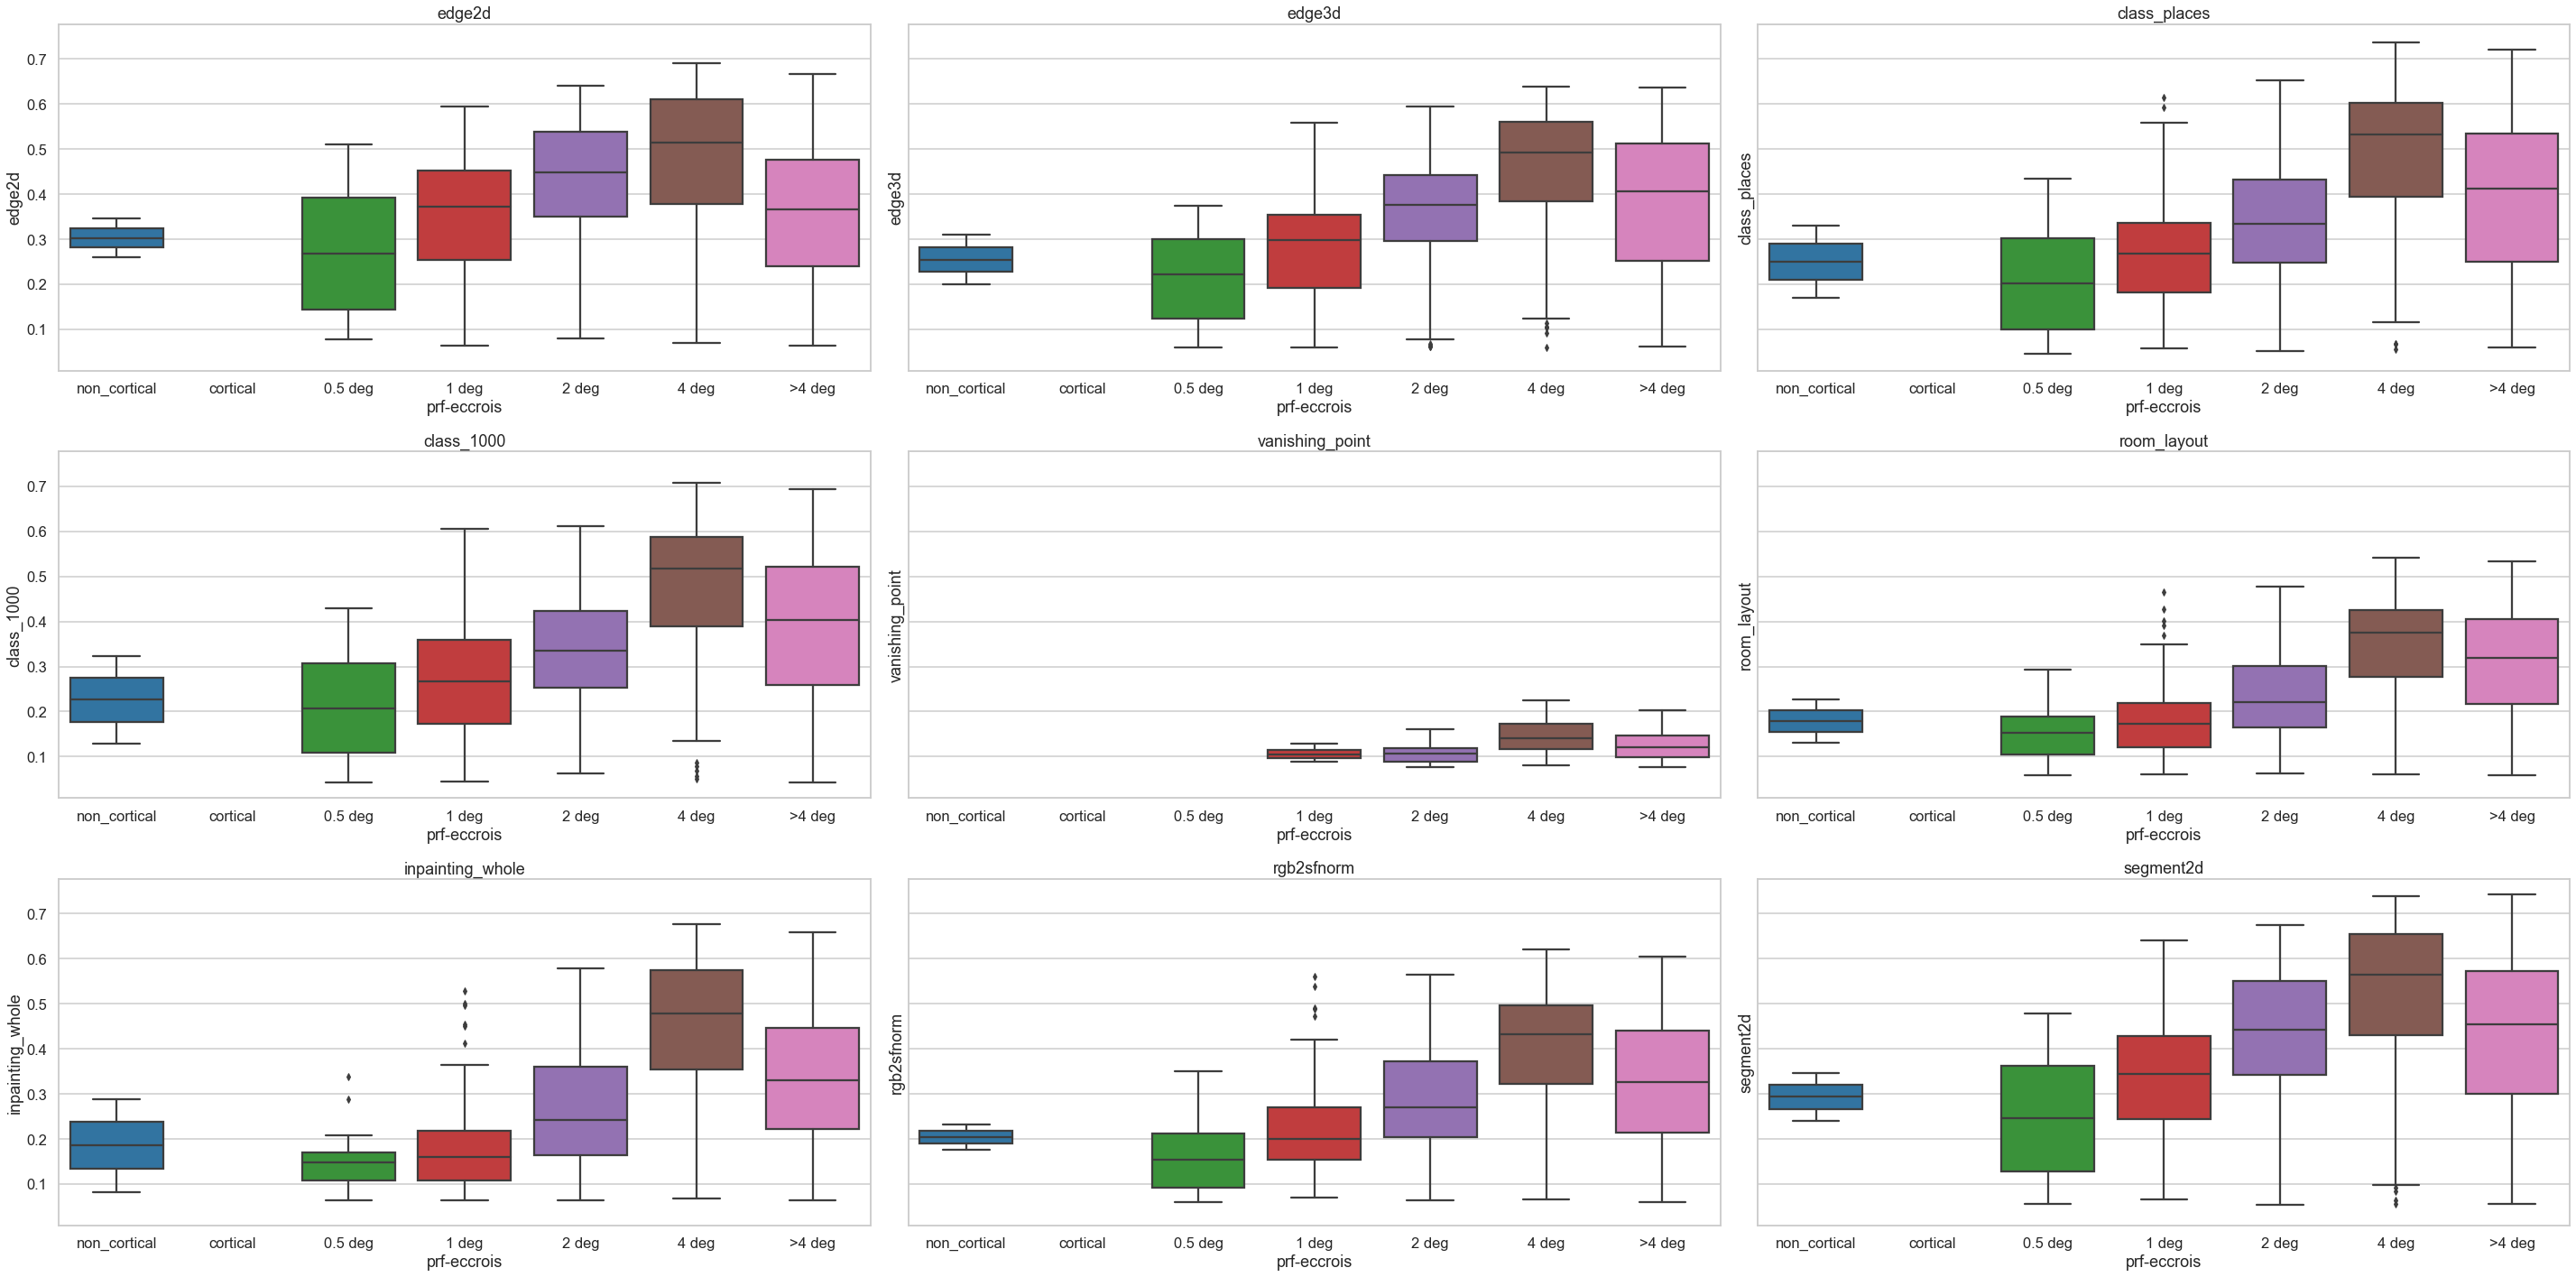

In [87]:
violinplot_by_task_across_roi_dorsal_only("prf-eccrois")

In [75]:
def barplot_by_roi_across_task(roi):
    sns.set_style("whitegrid")
    sns.set_context("talk")
    df = df_dict[roi]
    col_n = np.ceil(len(roi_dict[roi].values())/2).astype(int)
    fig, axes = plt.subplots(ncols=col_n, nrows=2, figsize=(50,20),sharey=True)
    for i, ax in enumerate(axes.flat):
#         if i==0:
#             #skip non-cortical
#             continue
        try:
            sub_df = df[df[roi] == list(roi_dict[roi].values())[i]]
            sns.barplot(x=sub_df.columns[1:], y=sub_df[sub_df.columns[1:]].mean(axis=0), ax=ax)
        except IndexError:
            continue
        ax.set_title(list(roi_dict[roi].values())[i])
    
    plt.tight_layout()

    plt.savefig("../figures/task_comparison/barplot_by_roi_across_task_subj%d_%s.png" % (subj,roi))

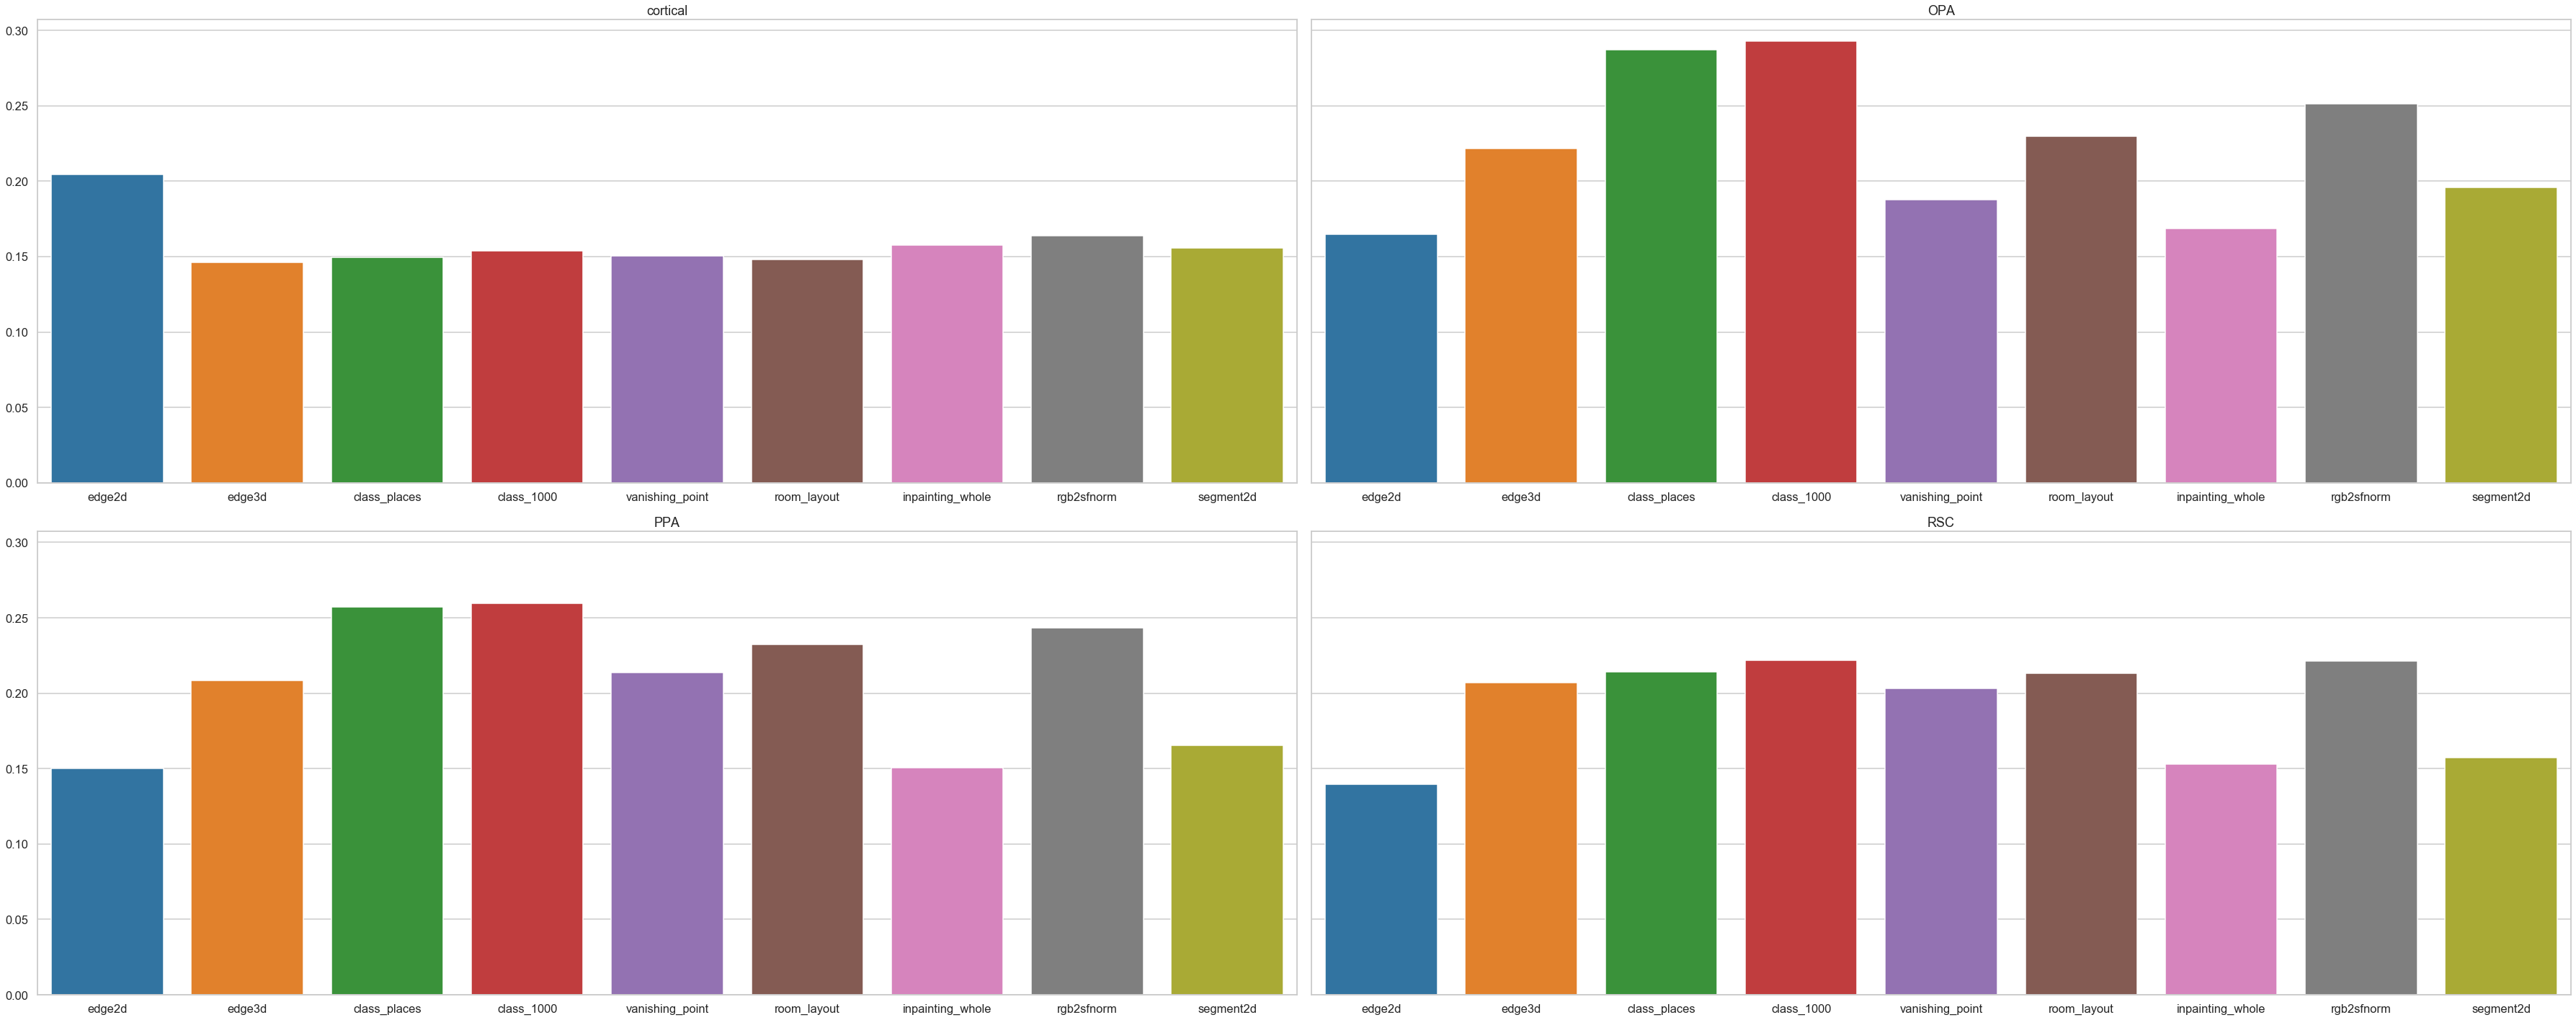

In [15]:
barplot_by_roi_across_task("floc-places")

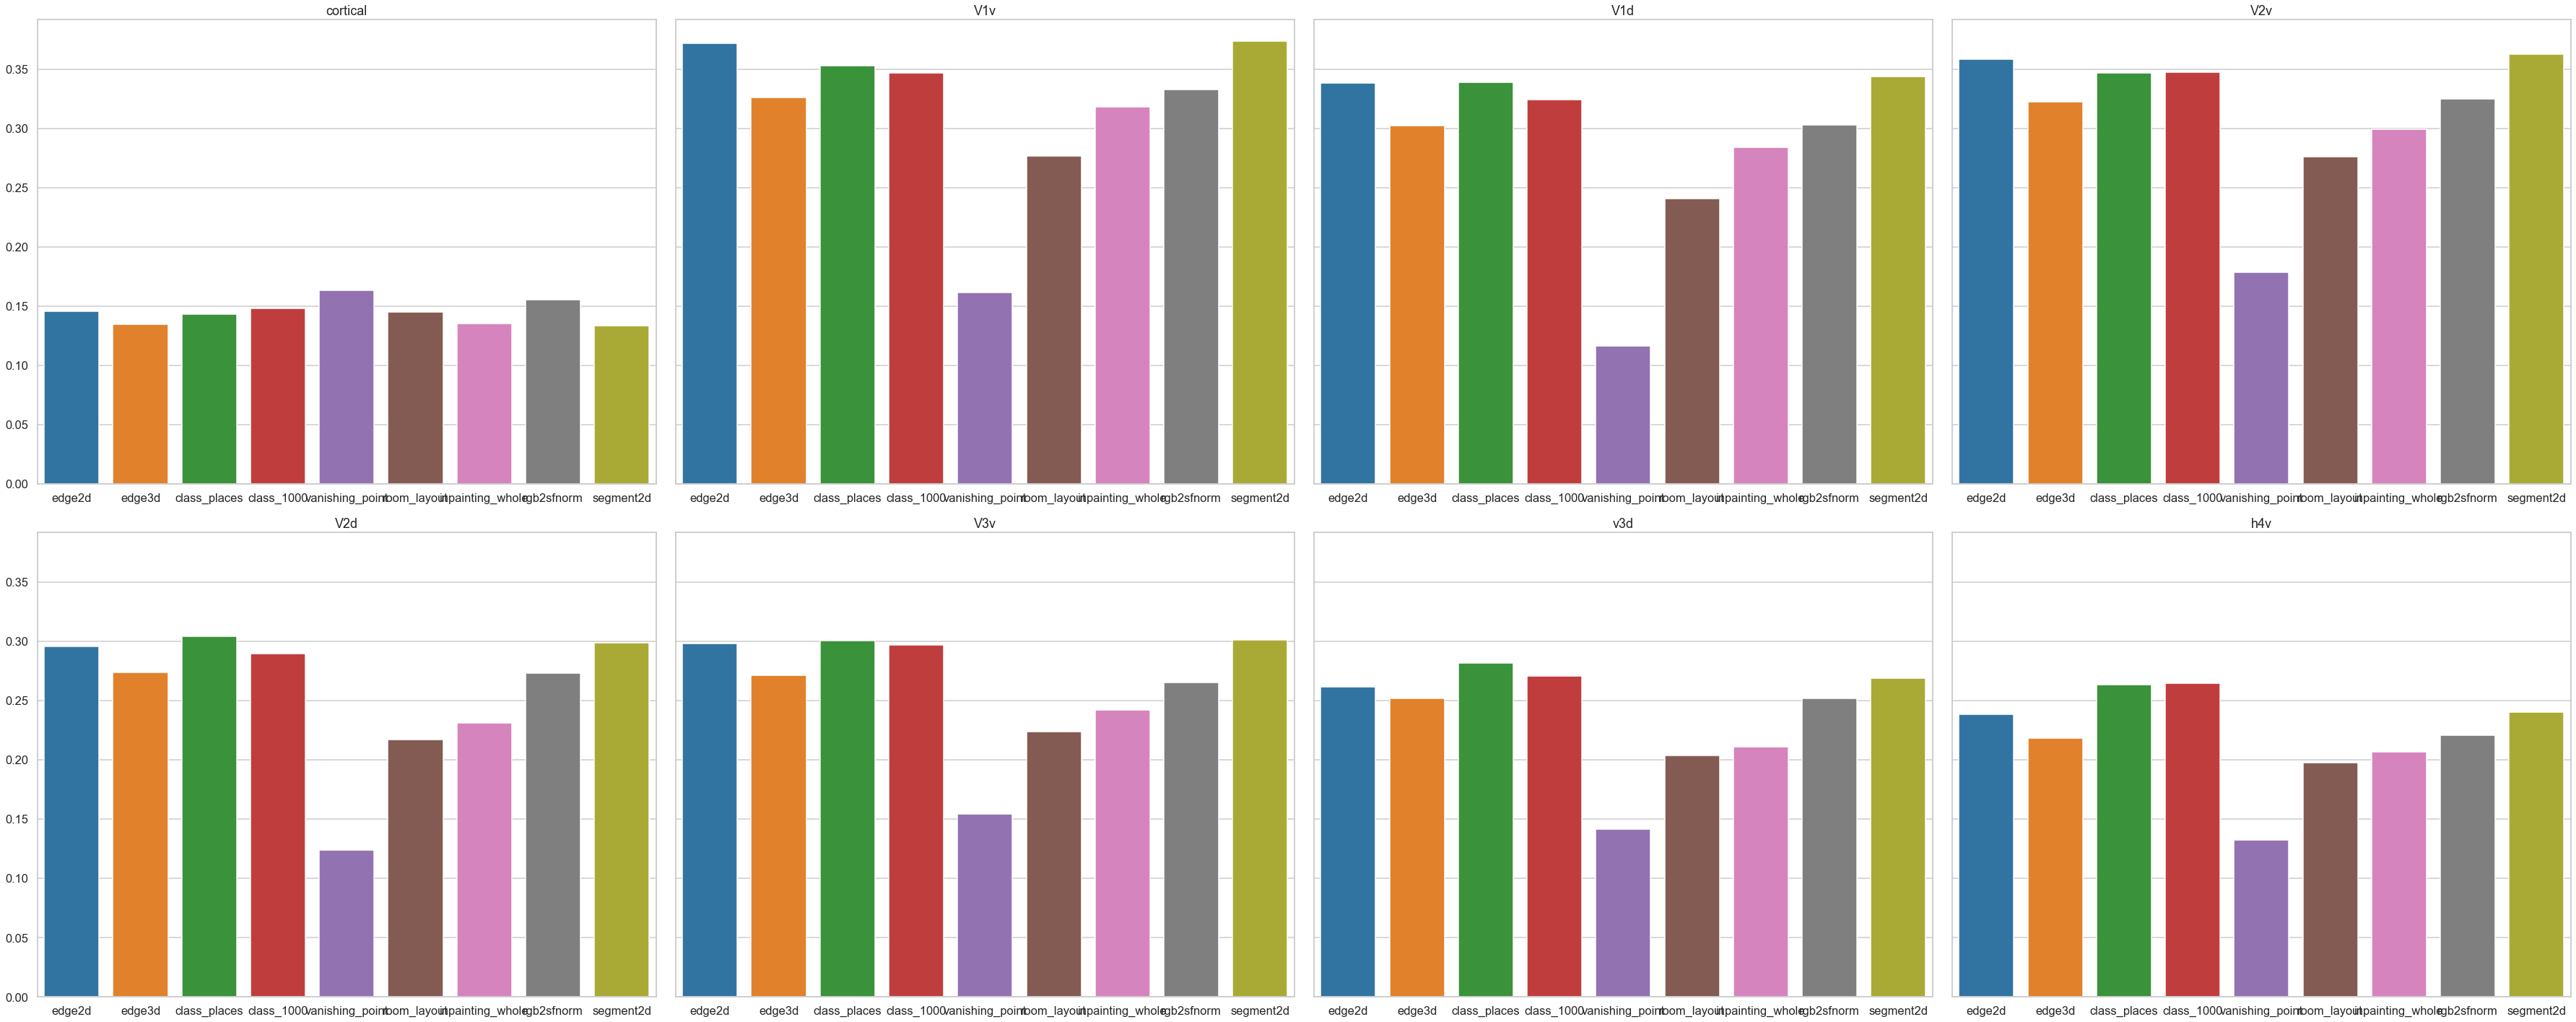

In [16]:
barplot_by_roi_across_task("prf-visualrois")

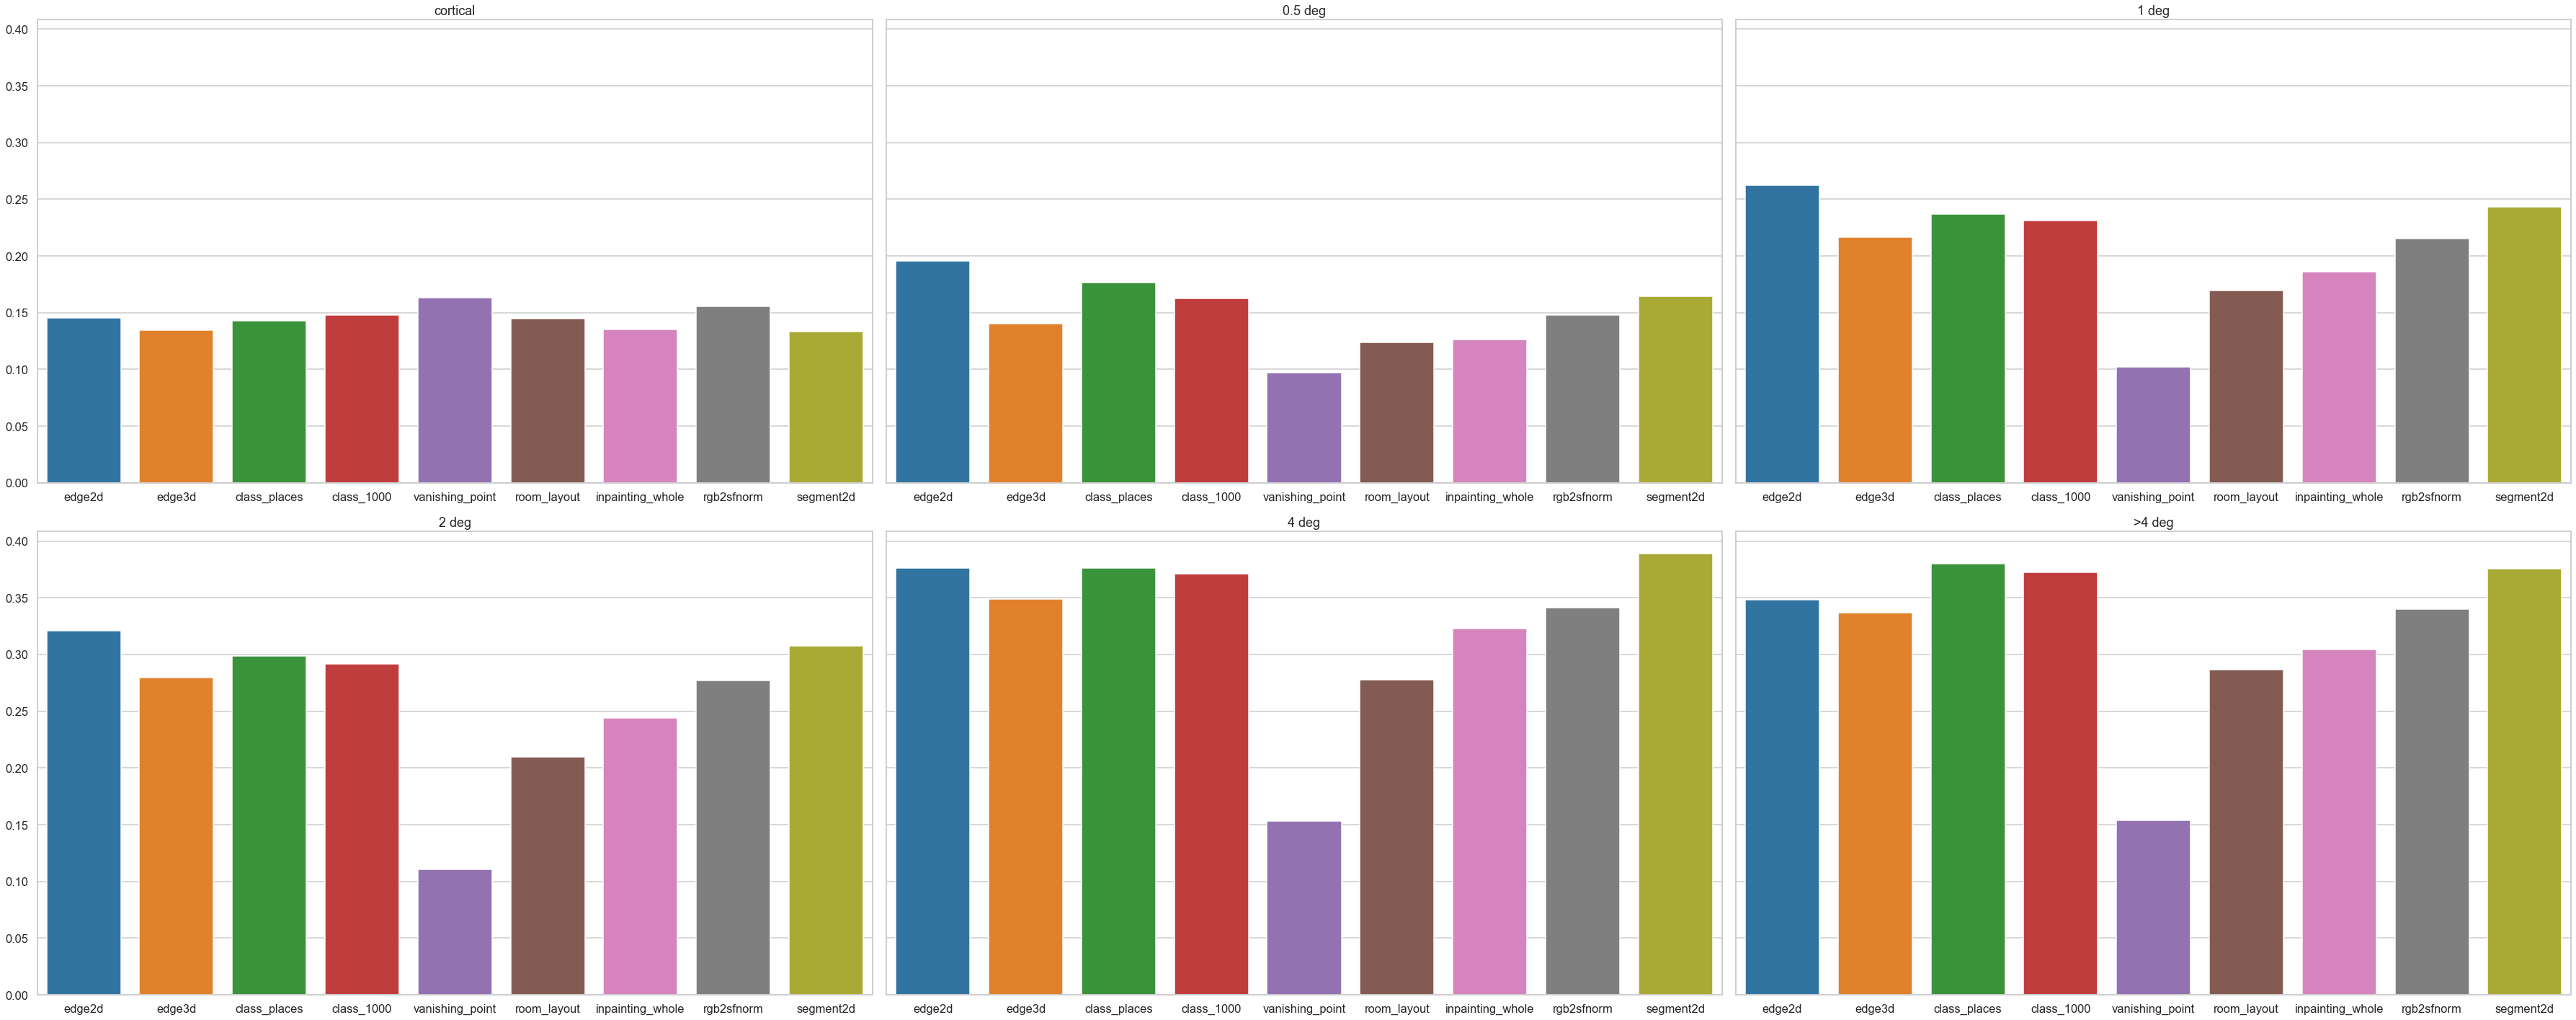

In [17]:
barplot_by_roi_across_task("prf-eccrois")

In [18]:
def lineplot_by_task_across_roi(roi):
    sns.set_style("whitegrid")
    sns.set_context("talk")
    df = df_dict[roi]
    plot_n = np.ceil(np.sqrt(len(TOI))).astype(int)
#     roi_n = len(roi_dict[roi].values())
    fig, axes = plt.subplots(ncols=plot_n, nrows=plot_n, figsize=(40,20),sharey=True)
    for i, ax in enumerate(axes.flat):
        try:
            sns.lineplot(x=roi, y=TOI[i], data=df, ax=ax, hue=roi)
        except IndexError:
            continue
        ax.set_title(TOI[i])
    plt.tight_layout()


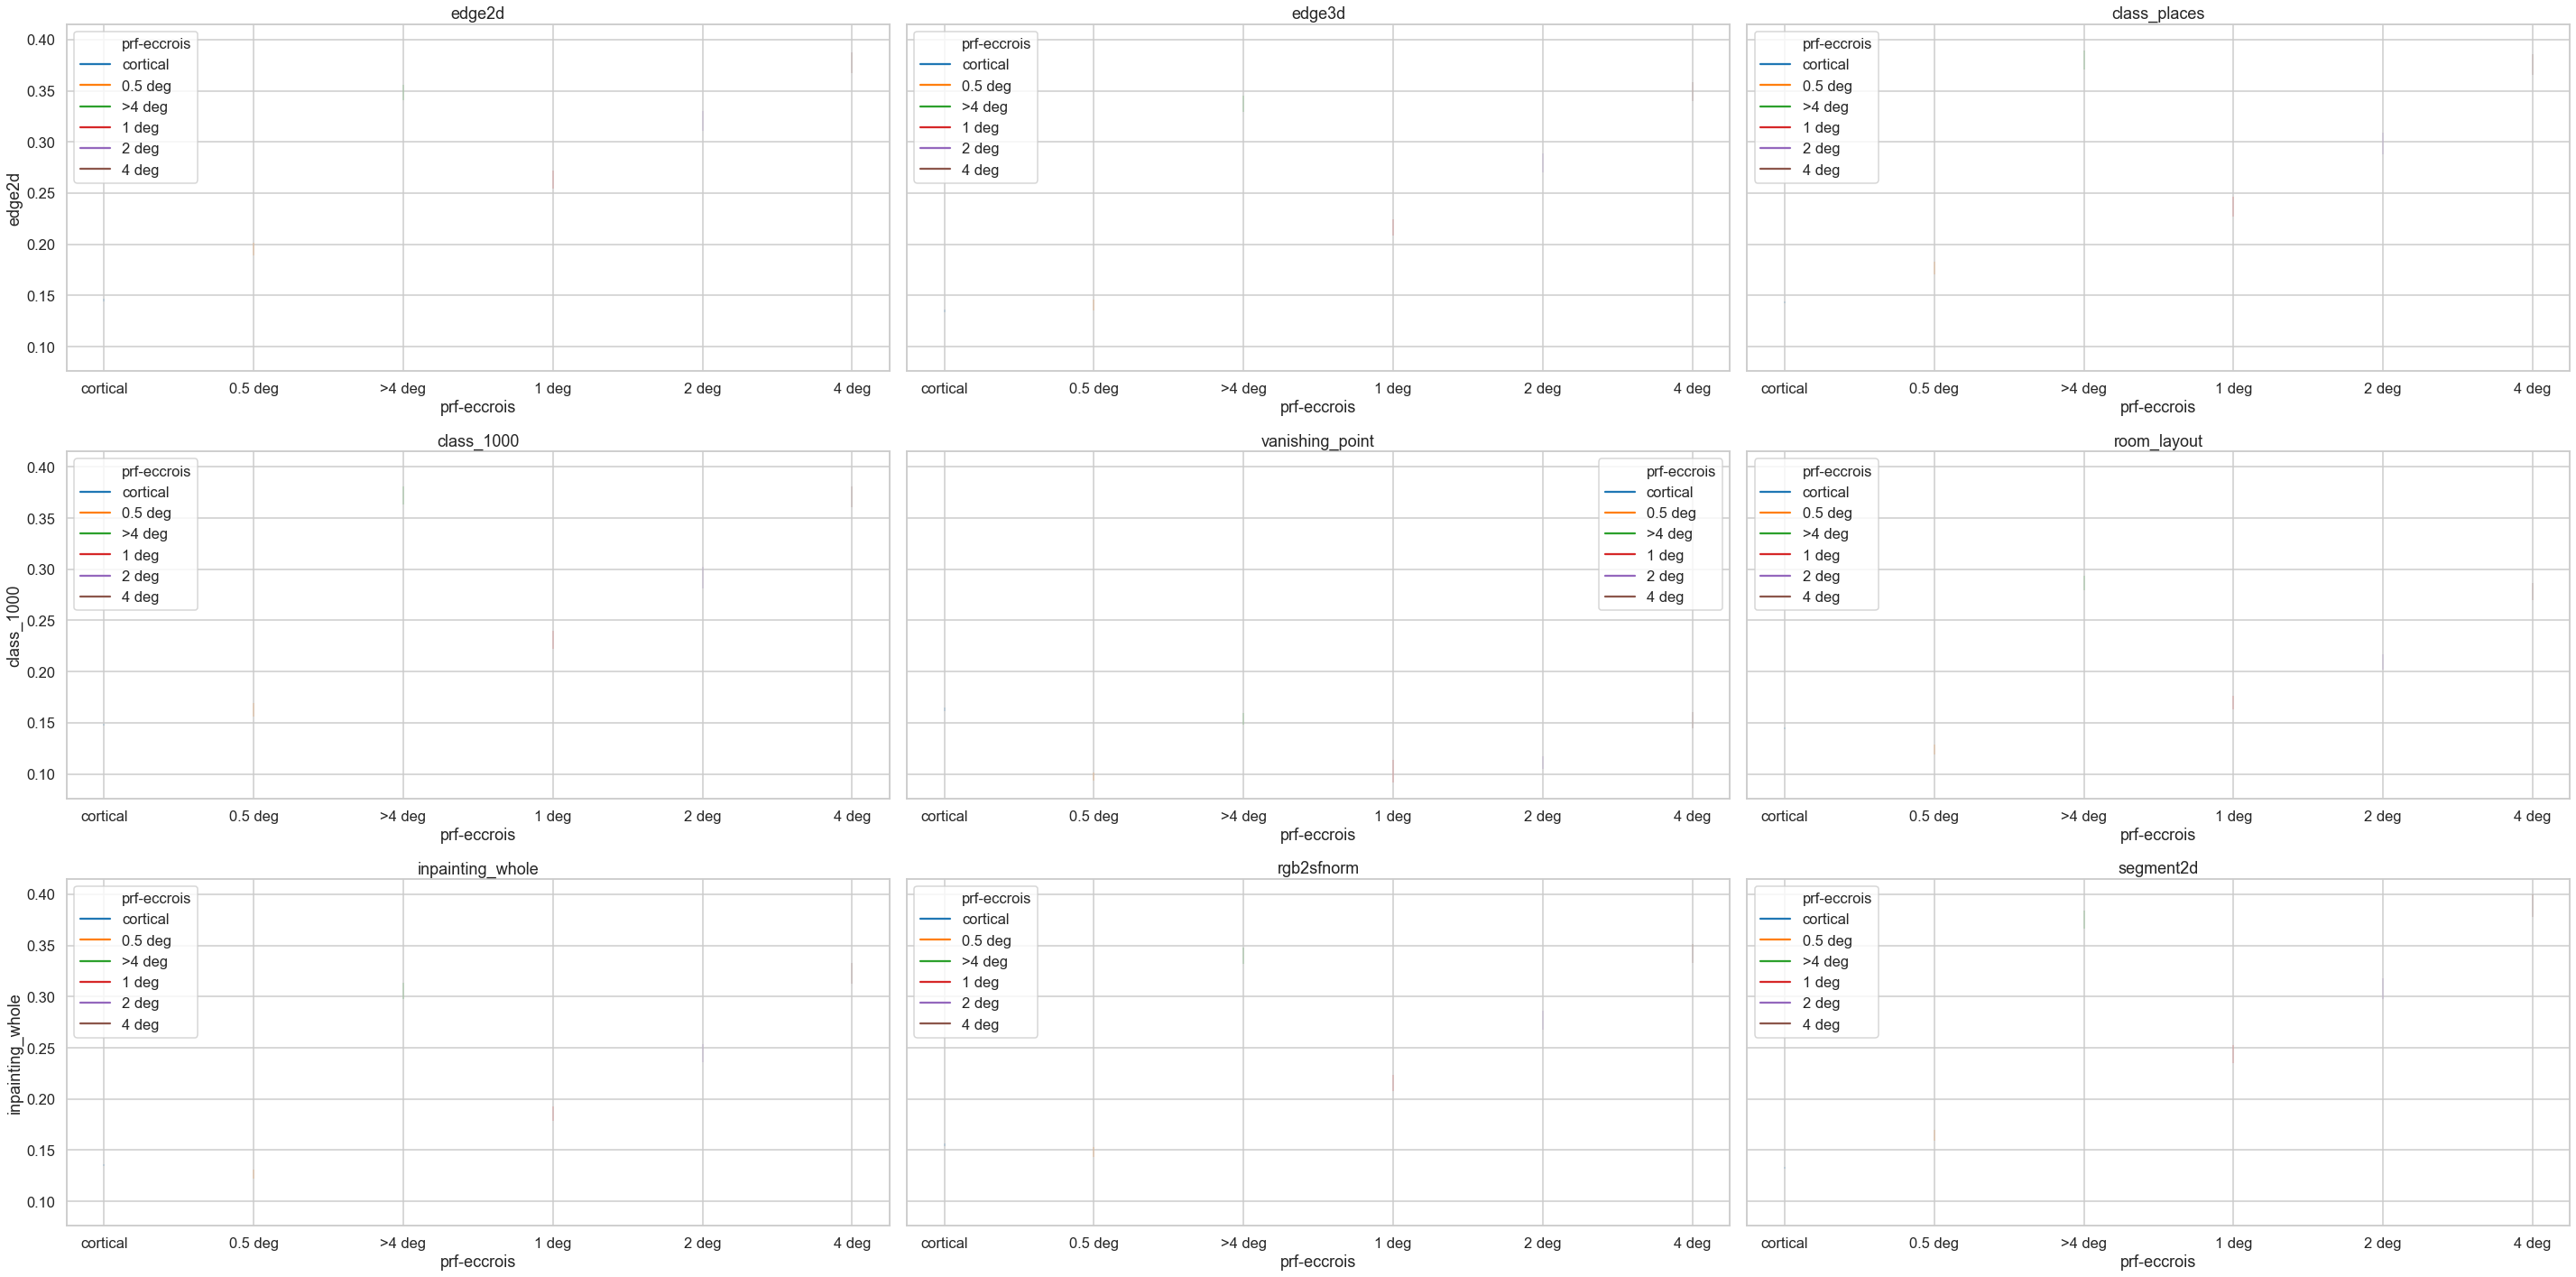

In [19]:
lineplot_by_task_across_roi("prf-eccrois")

### Ranksum test on model performance

NameError: name 'df' is not defined

<Figure size 432x288 with 0 Axes>

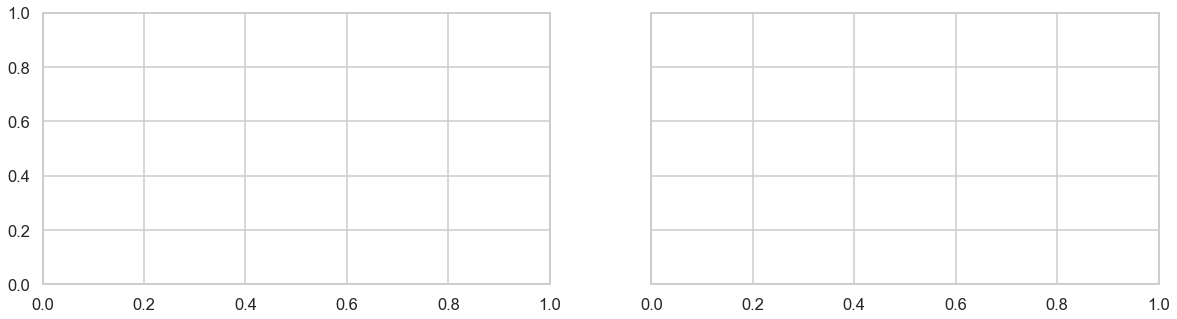

In [20]:
from scipy.stats import ranksums

TOI = ["room_layout", "vanishing_point","inpainting_whole"]

plt.figure()
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,5), sharey=True)
for i, task in enumerate(TOI[1:]):
    dist_diffs = list()
    for _, v in ecc_roi_names.items():
        rs = ranksums(df.room_layout[df.ecc_rois == v], df[task][df.ecc_rois == v])
        print(rs)
        dist_diffs.append(rs[0])
    sns.lineplot(x=list(ecc_roi_names.keys()), y=dist_diffs, ax=axes.flat[i])
    axes.flat[i].set_xlabel("Ecc ROIS")
    axes.flat[i].set_ylabel("Ranksum")
    axes.flat[i].set_title("%s vs room_layout" % task )
    

    

### Ranksum test on prediction

In [ ]:
prediction = load_data(model, task, subj, measure="pred")

def get_voxels(model_list, subj):
    datamat = list()
    for l in model_list:
        data = load_data("taskrepr", task=l, subj=subj, measure="corr")
        datamat.append(data)
    datamat = np.array(datamat)
    return datamat

In [52]:
pred_out = load_data("taskrepr", "inpainting_whole", subj, measure="pred")[0,...]
prediction = pred_out[0, ...]

In [ ]:
ranksum

In [57]:
prediction.shape

(1500, 90184)